# Project Details

ViolenceXplainar 

Research and development project

Supervisor: Mr. Hassan Mustafa

Group members: Tehreem Khawar(18I-0489), Iqra Aziz(18i-0491), Hafsa(18i-405)

# Code References

http://www.heatmapping.org/

https://git.tu-berlin.de/gmontavon/lrp-tutorial

# Importing Libraries

In [1]:
import cv2
import numpy
import torch
import utils
from PIL import Image
from torchvision import transforms
import torchvision

# Fetching Input Image and Resizing it

In [2]:

# img = numpy.array(cv2.imread('/home/violencexplainar/Desktop/testset_images/ambulance.jpg'))[...,::-1]/255.0

filename = ("/home/violencexplainar/Desktop/testset_images/blackwidow.jpg")
img = Image.open(filename)
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

X=input_batch

Input Dimensions

In [3]:
X.shape

torch.Size([1, 3, 224, 224])

# Model Layers

In [4]:
model = torchvision.models.vgg16(pretrained=True); model.eval()
layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)

print("Model has ",L, " Layers")
print(model.eval())

Model has  38  Layers
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2,

# Forward Activations

In [5]:
A = [X]+[None]*L
for l in range(L):
    A[l+1] = layers[l].forward(A[l])
    print ("Layer ",l,": ",A[l].shape)
    

Layer  0 :  torch.Size([1, 3, 224, 224])
Layer  1 :  torch.Size([1, 64, 224, 224])
Layer  2 :  torch.Size([1, 64, 224, 224])
Layer  3 :  torch.Size([1, 64, 224, 224])
Layer  4 :  torch.Size([1, 64, 224, 224])
Layer  5 :  torch.Size([1, 64, 112, 112])
Layer  6 :  torch.Size([1, 128, 112, 112])
Layer  7 :  torch.Size([1, 128, 112, 112])
Layer  8 :  torch.Size([1, 128, 112, 112])
Layer  9 :  torch.Size([1, 128, 112, 112])
Layer  10 :  torch.Size([1, 128, 56, 56])
Layer  11 :  torch.Size([1, 256, 56, 56])
Layer  12 :  torch.Size([1, 256, 56, 56])
Layer  13 :  torch.Size([1, 256, 56, 56])
Layer  14 :  torch.Size([1, 256, 56, 56])
Layer  15 :  torch.Size([1, 256, 56, 56])
Layer  16 :  torch.Size([1, 256, 56, 56])
Layer  17 :  torch.Size([1, 256, 28, 28])
Layer  18 :  torch.Size([1, 512, 28, 28])
Layer  19 :  torch.Size([1, 512, 28, 28])
Layer  20 :  torch.Size([1, 512, 28, 28])
Layer  21 :  torch.Size([1, 512, 28, 28])
Layer  22 :  torch.Size([1, 512, 28, 28])
Layer  23 :  torch.Size([1, 512

Highest score classes after forward pass 

In [6]:
scores = numpy.array(A[-1].data.view(-1))
ind = numpy.argsort(-scores)

for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

black widow, Latrode ( 75): 17.041
barn spider, Araneus ( 73): 15.938
black and gold garde ( 72): 13.037
                tick ( 78): 11.843
harvestman, daddy lo ( 70): 11.742
garden spider, Arane ( 74): 11.568
wolf spider, hunting ( 77): 11.439
spider web, spider's (815): 10.626
 ant, emmet, pismire (310):  8.332
bolo tie, bolo, bola (451):  8.188


# Backward pass Relevances

In [7]:
T = torch.FloatTensor((1.0*(numpy.arange(1000)==75).reshape([1,1000,1,1])))
print(T[0][483])
R = [None]*L + [(A[-1]*T).data]


tensor([[0.]])


In [8]:
print(L)
for l in range(1,L)[::-1]:
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

        if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
        if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

        z = incr(utils.newlayer(layers[l],rho).forward(A[l]))  # step 1
        s = (R[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = A[l].grad                  # step 3
        R[l] = (A[l]*c).data                                   # step 4
        
        print("Relevance on layer ",l,":",R[l].shape)
        
    else:
        layers[l]
        R[l] = R[l+1]
#         print("else",l,layers[l])

38
Relevance on layer  37 : torch.Size([1, 4096, 1, 1])
Relevance on layer  34 : torch.Size([1, 4096, 1, 1])
Relevance on layer  31 : torch.Size([1, 512, 7, 7])
Relevance on layer  30 : torch.Size([1, 512, 14, 14])
Relevance on layer  28 : torch.Size([1, 512, 14, 14])
Relevance on layer  26 : torch.Size([1, 512, 14, 14])
Relevance on layer  24 : torch.Size([1, 512, 14, 14])
Relevance on layer  23 : torch.Size([1, 512, 28, 28])
Relevance on layer  21 : torch.Size([1, 512, 28, 28])
Relevance on layer  19 : torch.Size([1, 512, 28, 28])
Relevance on layer  17 : torch.Size([1, 256, 28, 28])
Relevance on layer  16 : torch.Size([1, 256, 56, 56])
Relevance on layer  14 : torch.Size([1, 256, 56, 56])
Relevance on layer  12 : torch.Size([1, 256, 56, 56])
Relevance on layer  10 : torch.Size([1, 128, 56, 56])
Relevance on layer  9 : torch.Size([1, 128, 112, 112])
Relevance on layer  7 : torch.Size([1, 128, 112, 112])
Relevance on layer  5 : torch.Size([1, 64, 112, 112])
Relevance on layer  4 : tor

# Heatmaps for VGG

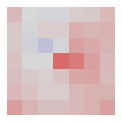

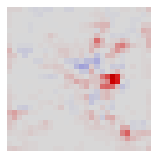

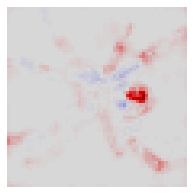

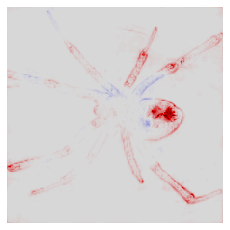

In [9]:
for i,l in enumerate([31,21,11,1]):
    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)